In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compare the same dataset with different starting counts

Dataset `2026_01_12__18_50_13` has a starting copynumber of 100, while dataset `2026_01_14__22_38_47` has a starting count of 200

In [8]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme

PALETTE = 'viridis'
set_theme()

top_write_dir = os.path.join('data', '26_sensitivity_peak2')

Load all the data
- original dataset
- resimulation of dataset with starting copynumber = 100
- resimulation of dataset with starting copynumber = 200

In [ ]:
fn_og = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
fn1 = 'data/simulate_circuits/2026_01_12__18_50_13/analytics.json'
fn2 = 'data/simulate_circuits/2026_01_14__22_38_47/analytics.json'
df_og = pd.read_csv(fn_og)
df1 = pd.read_json(fn1)
df2 = pd.read_json(fn2)
df1 = df1.explode(df1.columns.to_list()).reset_index(drop=True)
df2 = df2.explode(df2.columns.to_list()).reset_index(drop=True)


Process analytics into dataframes that match the dataframe of the original dataset

In [ ]:
names_species_input = df_og['sample_name'].unique()
n_species_input = len(names_species_input)
n_species_total = int(len(df1) / len(df_og) * n_species_input)
df1['sample_name'] = (np.arange(n_species_total) * np.ones((int(len(df1)/n_species_total), n_species_total))).flatten()
df1 = df1[df1['sample_name'].isin(list(np.arange(n_species_total)[-n_species_input:]))].reset_index(drop=True)
df2['sample_name'] = (np.arange(n_species_total) * np.ones((int(len(df2)/n_species_total), n_species_total))).flatten()
df2 = df2[df2['sample_name'].isin(list(np.arange(n_species_total)[-n_species_input:]))].reset_index(drop=True)
df1['sample_name'] = df1['sample_name'].map(lambda x: names_species_input[int(x - (n_species_total - n_species_input))])
df2['sample_name'] = df2['sample_name'].map(lambda x: names_species_input[int(x - (n_species_total - n_species_input))])
len(df1), len(df2)


Copy identity columns from original dataset to the resimulated datasets

In [36]:
cols_to_add = ['circuit_name', 'mutation_name', 'mutation_num']
df1[cols_to_add] = df_og[cols_to_add]
df2[cols_to_add] = df_og[cols_to_add]

# Visualise

Text(0.5, 1.0, 'The sensitivity peak is not due to the starting copynumber')

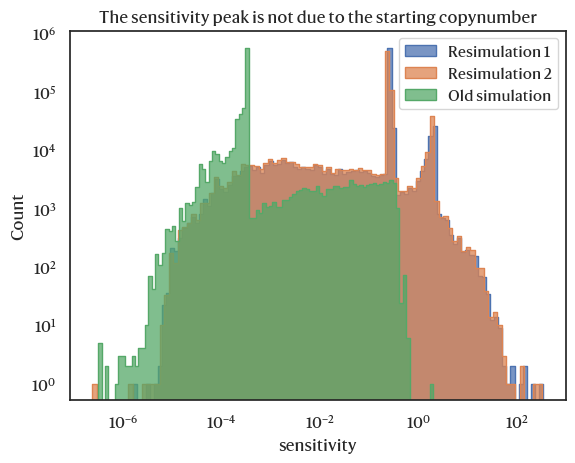

In [52]:
filt = lambda d: d[d['sample_name'] == 'RNA_2']
sns.histplot(filt(df1), x='sensitivity', bins=100, log_scale=(True, False), element='step')
sns.histplot(filt(df2), x='sensitivity', bins=100, log_scale=(True, False), element='step')
sns.histplot(filt(df_og), x='sensitivity', bins=100, log_scale=(True, False), element='step')
plt.yscale('log')
plt.legend(['Resimulation 1', 'Resimulation 2', 'Old simulation'])
plt.title('The sensitivity peak is not due to the starting copynumber')

/tmp/ipykernel_1340658/2434799143.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
/tmp/ipykernel_1340658/2434799143.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
/tmp/ipykernel_1340658/2434799143.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)


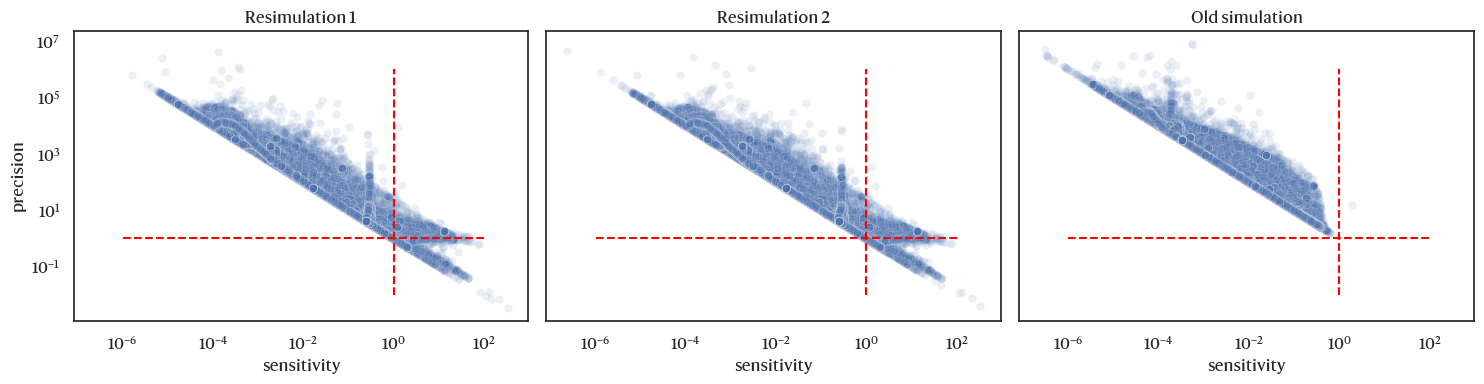

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
for i, (d, title) in enumerate(zip([df1, df2, df_og], ['Resimulation 1', 'Resimulation 2', 'Old simulation'])):
    sns.scatterplot(filt(d), x='sensitivity', y='precision', palette=PALETTE, ax=axs[i], alpha=0.1)
    axs[i].vlines(x=1, ymin=1e-2, ymax=1e6, colors='red', linestyles='dashed')
    axs[i].hlines(y=1, xmin=1e-6, xmax=1e2, colors='red', linestyles='dashed')
    axs[i].set_title(title)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
plt.tight_layout()

# Check configs for other simulation settings

In [70]:
cfg1 = os.path.join(os.path.dirname(fn1), 'config.json')
with open(cfg1, 'r') as f:
    config1 = json.load(f)
cfg2 = os.path.join(os.path.dirname(fn2), 'config.json')
with open(cfg2, 'r') as f:
    config2 = json.load(f)
cfg_og = os.path.join(os.path.dirname(fn_og), 'ensemble_config.json')
with open(cfg_og, 'r') as f:
    config_og = json.load(f)['base_configs_ensemble']['mutation_effect_on_interactions_signal']

Config 1 and 2 for simulation setting are the same, since we only changed the starting copynumbers. Therefore, we can compare the configuration of either one to that of the original dataset to see why the peak shifted.

In [73]:
config1['simulation'] == config2['simulation']

True

Here are the differences in the simulation settings that could be responsible for the peak shift:

In [74]:
for k, v in config1['simulation'].items():
    if config_og['simulation'].get(k) != v:
        print(f'Key: {k}')
        print(f'Old: {config_og["simulation"].get(k)}')
        print(f'New: {v}')
        print('---')

Key: dt0
Old: 0.01
New: 0.0001
---
Key: t1
Old: 500
New: 1000
---
Key: tmax
Old: 2000
New: 8000
---
Key: threshold_steady_states
Old: 0.05
New: 0.02
---
Key: save_steps
Old: None
New: 100
---
Key: save_steps_uselog
Old: None
New: True
---
